In [1]:
import numpy as np
import pandas as pd

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
seed = 100
import re
import requests
import plotly.express as px
from plotly import graph_objs as go
import plotly.figure_factory as ff
import nltk

## Load DataSet

In [2]:
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json',lines=True)

In [3]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
df['headline'][0]

'thirtysomething scientists unveil doomsday clock of hair loss'

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [6]:
df.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [7]:
# No Null Values is Dataset

In [8]:
df['source_of_text'] = df['article_link'].apply(lambda x: re.findall(r'\w+', x)[2])
df.head()

,is_sarcastic,headline,article_link,source_of_text
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,theonion
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,huffingtonpost
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,huffingtonpost
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,theonion
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,theonion


In [9]:
df = df.drop(['article_link'],axis = 1)

In [10]:
df.head()

,is_sarcastic,headline,source_of_text
0,1,thirtysomething scientists unveil doomsday clo...,theonion
1,0,dem rep. totally nails why congress is falling...,huffingtonpost
2,0,eat your veggies: 9 deliciously different recipes,huffingtonpost
3,1,inclement weather prevents liar from getting t...,theonion
4,1,mother comes pretty close to using word 'strea...,theonion


### EDA

In [11]:
px.pie(df,names='is_sarcastic',labels=['Sarcastic','Acclaim'],title='Sarcasam Vs Acclaim')

Text(0.5, 0, 'Target')

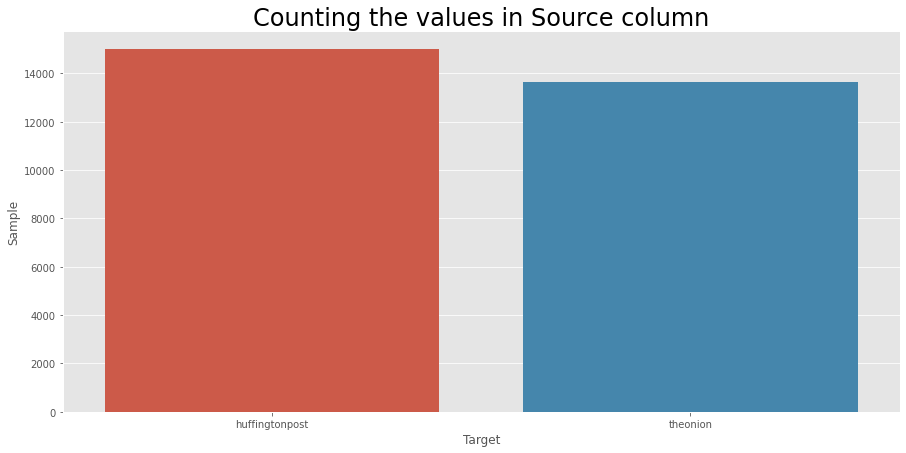

In [12]:
plt.style.use('ggplot')
target_counts=df['source_of_text'].value_counts()
plt.figure(figsize = (15,7))
sns.barplot(y=target_counts,x=target_counts.index)
plt.title("Counting the values in Source column",fontsize = 24)
plt.ylabel('Sample')
plt.xlabel('Target')

### Pattern of usage of words in the Headlines

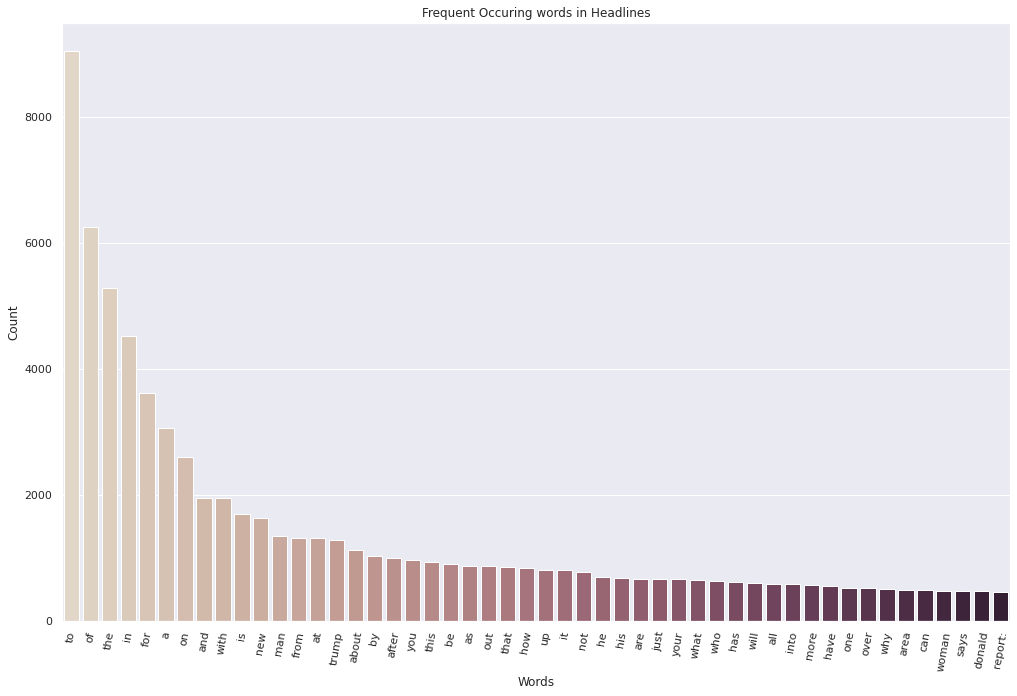

In [13]:
all_words = df['headline'].str.split(expand=True).unstack().value_counts()
all=pd.DataFrame(all_words).reset_index()
sns.set(rc={'figure.figsize':(17,11)})
sns.barplot(x=all['index'][0:50], y=all[0][0:50], data=all,palette="ch:.25")
plt.xlabel('Words')  # Add an x-label to the axes.
plt.ylabel('Count')  # Add a y-label to the axes.
plt.title("Frequent Occuring words in Headlines") 
plt.xticks(rotation=80);

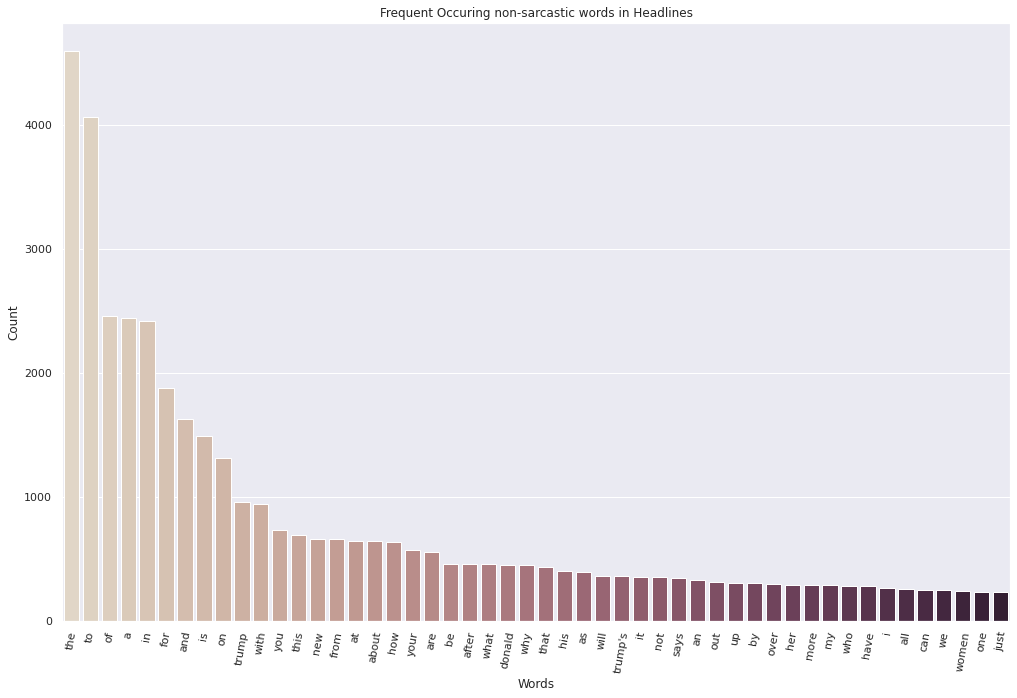

In [14]:
non_sarc=pd.DataFrame(df[df['is_sarcastic']==0]['headline'].str.split(expand=True).unstack().value_counts()).reset_index()
sns.set(rc={'figure.figsize':(17,11)})
sns.barplot(x=non_sarc['index'][0:50], y=non_sarc[0][0:50], data=non_sarc,palette="ch:.25")
plt.xlabel('Words')  # Add an x-label to the axes.
plt.ylabel('Count')  # Add a y-label to the axes.
plt.title("Frequent Occuring non-sarcastic words in Headlines") 
plt.xticks(rotation=80);


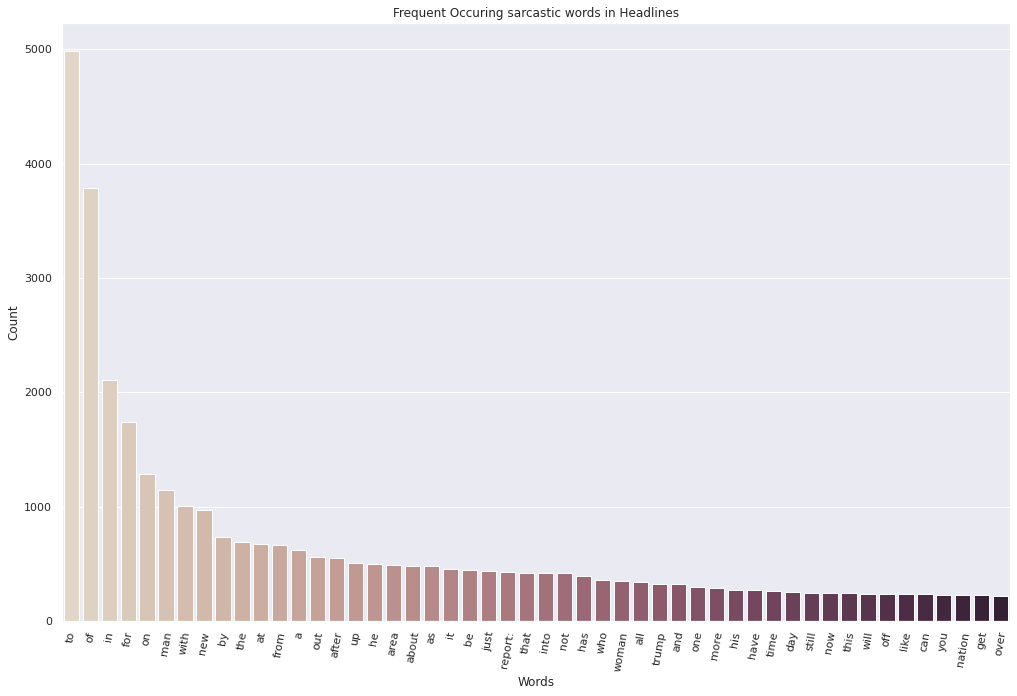

In [15]:
sarc=pd.DataFrame(df[df['is_sarcastic']==1]['headline'].str.split(expand=True).unstack().value_counts()).reset_index()
sns.set(rc={'figure.figsize':(17,11)})
sns.barplot(x=sarc['index'][0:50], y=sarc[0][0:50], data=sarc,palette="ch:.25")
plt.xlabel('Words')  # Add an x-label to the axes.
plt.ylabel('Count')  # Add a y-label to the axes.
plt.title("Frequent Occuring sarcastic words in Headlines") 
plt.xticks(rotation=80);

In [17]:
import nltk
nltk.download('stopwords')
nltk.download("wordnet")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
import spacy
nlp = spacy.load('en_core_web_sm')


In [19]:
!pip install contractions

     |████████████████████████████████| 321 kB 7.0 MB/s 
     |████████████████████████████████| 284 kB 48.3 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85450 sha256=12b88542a967294f4652146b34ddd2671001391e69e69fb2e3bb17f6cc0e5d64
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [20]:
import nltk
nltk.download('stopwords')
import re 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize
#import contractions
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Pre-Processing

In [21]:
df['headline']=df['headline'].str.lower()
# Code to remove the Hashtags from the text
df['headline']=df['headline'].apply(lambda x:re.sub(r'\B#\S+','',x))
# Code to remove the links from the text
df['headline']=df['headline'].apply(lambda x:re.sub(r"http\S+", "", x))
# Code to remove the Special characters from the text 
df['headline']=df['headline'].apply(lambda x:' '.join(re.findall(r'\w+', x)))
# Code to substitute the multiple spaces with single spaces
df['headline']=df['headline'].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
# Code to remove all the single characters in the text
df['headline']=df['headline'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
# Remove the twitter handlers
df['headline']=df['headline'].apply(lambda x:re.sub('@[^\s]+','',x))

In [22]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['headline_clean'] = df['headline'].apply(remove_stopwords)
df.head()

,is_sarcastic,headline,source_of_text,headline_clean
0,1,thirtysomething scientists unveil doomsday clo...,theonion,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails why congress is falling ...,huffingtonpost,dem rep totally nails congress falling short g...
2,0,eat your veggies 9 deliciously different recipes,huffingtonpost,eat veggies 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...,theonion,inclement weather prevents liar getting work
4,1,mother comes pretty close to using word stream...,theonion,mother comes pretty close using word streaming...


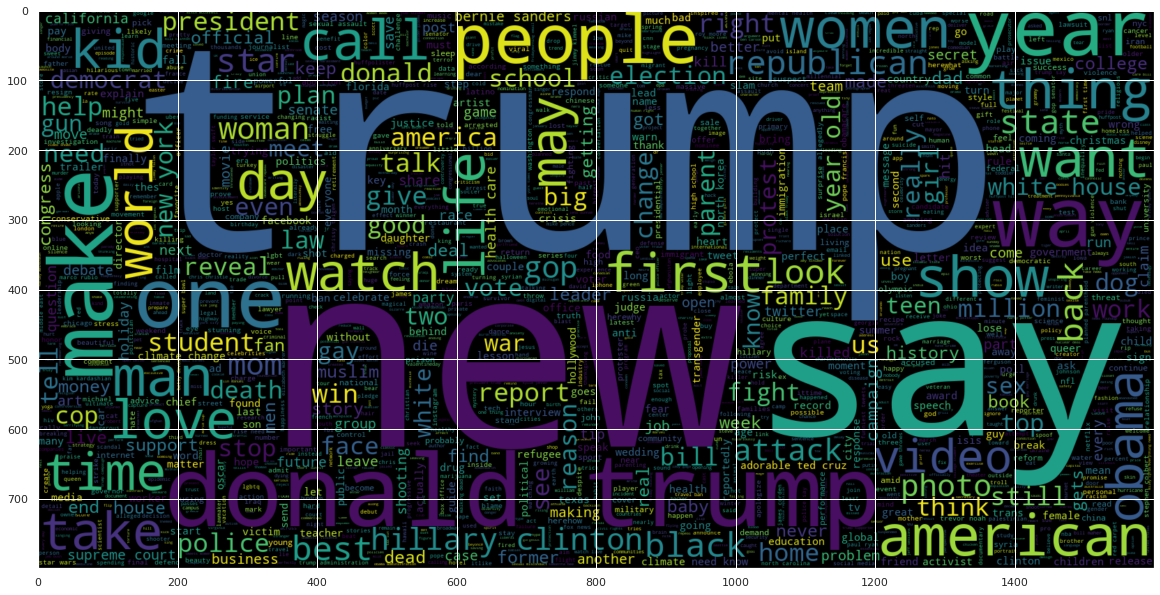

In [23]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline_clean))
plt.imshow(wc , interpolation = 'bilinear')

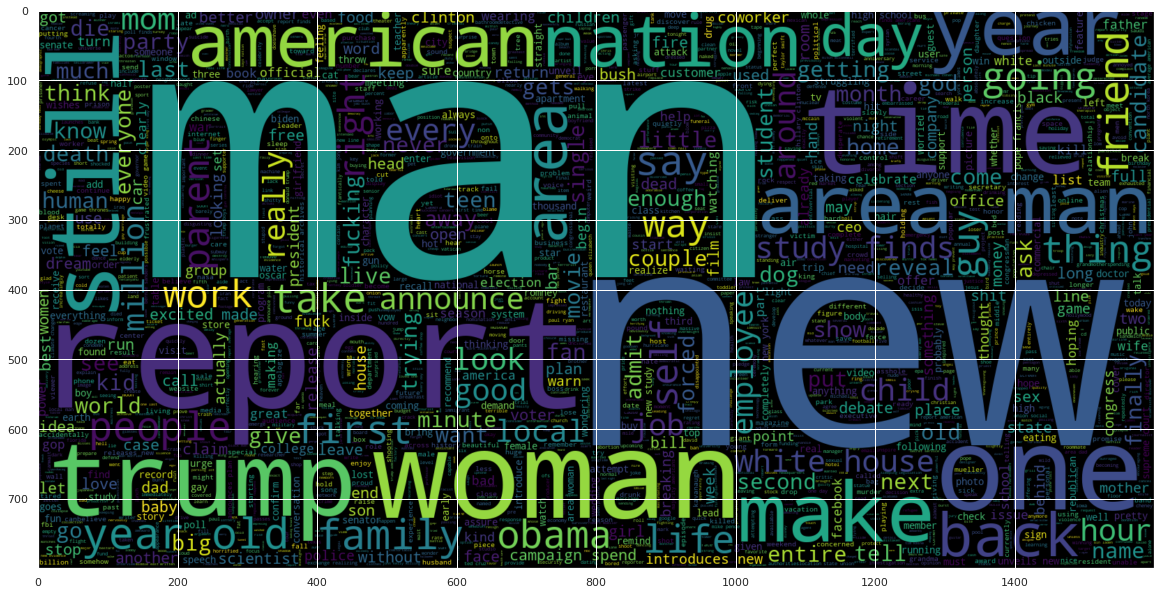

In [24]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline_clean))
plt.imshow(wc , interpolation = 'bilinear')

In [25]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

df['tokenized'] = df['headline_clean'].apply(lambda x: tokenization(x.lower()))
df.head()

,is_sarcastic,headline,source_of_text,headline_clean,tokenized
0,1,thirtysomething scientists unveil doomsday clo...,theonion,thirtysomething scientists unveil doomsday clo...,"[thirtysomething, scientists, unveil, doomsday..."
1,0,dem rep totally nails why congress is falling ...,huffingtonpost,dem rep totally nails congress falling short g...,"[dem, rep, totally, nails, congress, falling, ..."
2,0,eat your veggies 9 deliciously different recipes,huffingtonpost,eat veggies 9 deliciously different recipes,"[eat, veggies, 9, deliciously, different, reci..."
3,1,inclement weather prevents liar from getting t...,theonion,inclement weather prevents liar getting work,"[inclement, weather, prevents, liar, getting, ..."
4,1,mother comes pretty close to using word stream...,theonion,mother comes pretty close using word streaming...,"[mother, comes, pretty, close, using, word, st..."


In [26]:
sarcastic = df[df['is_sarcastic']==0]['headline_clean']
sarcastic[:10]

1     dem rep totally nails congress falling short g...
2           eat veggies 9 deliciously different recipes
5                                     white inheritance
6                         5 ways file taxes less stress
9                            lots parents know scenario
10         lesbian consideredfather indiana amazing one
11          amanda peet told daughter sex isspecial hug
12              know regarding current treatments ebola
13    chris christie suggests hillary clinton blame ...
15    uber ceo travis kalanick stepping trump econom...
Name: headline_clean, dtype: object

In [27]:
not_sarcastic = df[df['is_sarcastic']==1]['headline_clean']
not_sarcastic[:10]

0     thirtysomething scientists unveil doomsday clo...
3          inclement weather prevents liar getting work
4     mother comes pretty close using word streaming...
7     richard bransonglobal warming donation nearly ...
8     shadow government getting large meet marriott ...
14           ford develops new suv runs purely gasoline
16    area boy enters jumping touching tops doorways...
17                            area man traveling gurney
21    guard video game strict orders repeatedly pace...
25     secret service agent secret david alan grier fan
Name: headline_clean, dtype: object

In [28]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

df['headline_clean'] = df['headline_clean'].apply(stemm_text)
df.head()

,is_sarcastic,headline,source_of_text,headline_clean,tokenized
0,1,thirtysomething scientists unveil doomsday clo...,theonion,thirtysometh scientist unveil doomsday clock h...,"[thirtysomething, scientists, unveil, doomsday..."
1,0,dem rep totally nails why congress is falling ...,huffingtonpost,dem rep total nail congress fall short gender ...,"[dem, rep, totally, nails, congress, falling, ..."
2,0,eat your veggies 9 deliciously different recipes,huffingtonpost,eat veggi 9 delici differ recip,"[eat, veggies, 9, deliciously, different, reci..."
3,1,inclement weather prevents liar from getting t...,theonion,inclement weather prevent liar get work,"[inclement, weather, prevents, liar, getting, ..."
4,1,mother comes pretty close to using word stream...,theonion,mother come pretti close use word stream correct,"[mother, comes, pretty, close, using, word, st..."


### 100 most occuring words

In [30]:
all_words=[]
for i in range(len(df['tokenized'])):
    a=df['tokenized'][i]
    for i in a:
        all_words.append(i)
all_words=pd.Series(np.array(all_words))

common_words=all_words.value_counts()[:100].rename_axis('Common Words').reset_index(name='count')

fig = px.treemap(common_words, path=['Common Words'], values='count',template= "plotly_dark",title='100 Most Common Words In Headline')
fig.show()

NameError: ignored

### Comparison of the length of sarcastic and non-sarcastic headlines

In [31]:
df['text_len'] = df['headline'].apply(lambda x: len(x.split(' ')))

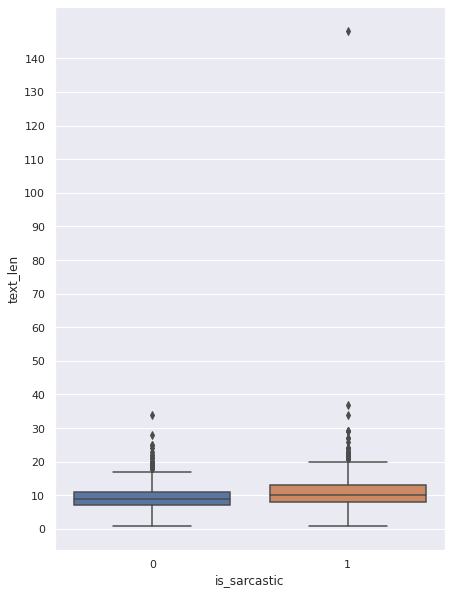

In [32]:
plt.figure(figsize = (7 ,10))
sns.boxplot(y='text_len', x="is_sarcastic", data=df)
y=df['text_len']
plt.yticks(np.arange(0, max(y), 10));

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [34]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

def print_score(classifier,X_train,y_train,X_test,y_test,train=True):
    if train == True:
        print("Training results:\n")
        print('Accuracy Score: {0:.4f}\n'.format(accuracy_score(y_train,classifier.predict(X_train))))
        print('Classification Report:\n{}\n'.format(classification_report(y_train,classifier.predict(X_train))))
        print('Confusion Matrix:\n{}\n'.format(confusion_matrix(y_train,classifier.predict(X_train))))
        res = cross_val_score(classifier, X_train, y_train, cv=10, n_jobs=-1, scoring='accuracy')
        print('Average Accuracy:\t{0:.4f}\n'.format(res.mean()))
        print('Standard Deviation:\t{0:.4f}'.format(res.std()))
        return accuracy_score(y_train,classifier.predict(X_train))
    elif train == False:
        print("Test results:\n")
        print('Accuracy Score: {0:.4f}\n'.format(accuracy_score(y_test,classifier.predict(X_test))))
        print('Classification Report:\n{}\n'.format(classification_report(y_test,classifier.predict(X_test))))
        print('Confusion Matrix:\n{}\n'.format(confusion_matrix(y_test,classifier.predict(X_test))))
        return accuracy_score(y_test,classifier.predict(X_test))

In [35]:
classifier_lr=LogisticRegression(max_iter = 500, random_state=42)
classifier_mnb=MultinomialNB()
classifier_rf=RandomForestClassifier(criterion='gini',
                                n_estimators=12, 
                                random_state=42)
classifier_svm=SVC(kernel='linear', gamma=1, probability=True, random_state=42)

In [36]:
# Construct some pipelines
pipe_lr = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
			              ('clf', classifier_lr )])

pipe_mnb = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
			              ('clf', classifier_mnb)])

pipe_rf = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
			              ('clf', classifier_rf)])


pipe_svm = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
			              ('clf', classifier_svm)])

In [37]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    #'clf__max_iter': (20,),
    #'clf__alpha': (0.00001, 0.000001),
    #'clf__penalty': ('l2', 'elasticnet'),
    #'clf__max_iter': (10, 50, 80)
}

In [38]:
#Spliting it into training and testing 
X = df['headline_clean']
y = df['is_sarcastic']

# Split into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y,test_size = 0.1,random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

25757 25757
2862 2862


In [39]:
# Set grid search params
param_range = [2,4]
param_range_fl = [1.0, 0.5]

grid_params_lr = [{'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__penalty': ('none', 'l2')
    }] 

grid_params_mnb = [{'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.5,1,2)}]

grid_params_rf = [{'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__criterion': ['gini'],
		'clf__min_samples_leaf': param_range,
		'clf__max_depth': param_range,
		'clf__min_samples_split': param_range[1:]}]

grid_params_svm = [{
    'clf__kernel': ['rbf']}]

# Construct grid searches
jobs = -1

gs_lr = RandomizedSearchCV(estimator=pipe_lr,
			param_distributions=grid_params_lr,
			scoring='accuracy',
			cv=10) 

gs_mnb = RandomizedSearchCV(estimator=pipe_mnb,
			param_distributions=grid_params_mnb,
			scoring='accuracy',
			cv=10) 

gs_rf = RandomizedSearchCV(estimator=pipe_rf,
			param_distributions=grid_params_rf,
			scoring='accuracy',
			cv=10, 
			n_jobs=jobs)



# List of pipelines for ease of iteration
grids = [gs_lr, gs_mnb, gs_rf]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression', 1: 'Multinomial Naive Bayes', 
		2: 'Random Forest', 
		3: 'Support Vector Machine'}

In [40]:
# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
	print('\nEstimator: %s' % grid_dict[idx])	
	# Fit grid search	
	gs.fit(x_train, y_train)
	# Best params
	print('Best params: %s' % gs.best_params_)
	# Best training data accuracy
	print('Best training accuracy: %.3f' % gs.best_score_)
	
# Save best grid search pipeline to file
#dump_file = 'best_gs_pipeline.pkl'
#joblib.dump(best_gs, dump_file, compress=1)
#print('\nSave %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

Performing model optimizations...

Estimator: Logistic Regression
Best params: {'vect__ngram_range': (1, 2), 'vect__max_df': 0.5, 'tfidf__use_idf': True, 'tfidf__norm': 'l2', 'clf__penalty': 'none'}
Best training accuracy: 0.785

Estimator: Multinomial Naive Bayes
Best params: {'vect__ngram_range': (1, 2), 'vect__max_df': 0.5, 'tfidf__use_idf': True, 'tfidf__norm': 'l2', 'clf__alpha': 0.5}
Best training accuracy: 0.797

Estimator: Random Forest
Best params: {'vect__ngram_range': (1, 2), 'vect__max_df': 0.75, 'tfidf__use_idf': True, 'tfidf__norm': 'l1', 'clf__min_samples_split': 4, 'clf__min_samples_leaf': 2, 'clf__max_depth': 4, 'clf__criterion': 'gini'}
Best training accuracy: 0.549


### Make the predictions with the model

### Best Random Forest

In [41]:
rf_best = gs_rf
rf_best

rf_train_predictions = rf_best.predict(x_train)
rf_predictions = rf_best.predict(x_test)

rf_train_probs = rf_best.predict_proba(x_train)[:, 1]
rf_probs = rf_best.predict_proba(x_test)[:, 1]

### Logistic Regression

In [42]:
lr_train_predictions = gs_lr.predict(x_train)
lr_predictions = gs_lr.predict(x_test)

lr_train_probs = gs_lr.predict_proba(x_train)[:, 1]
lr_probs = gs_lr.predict_proba(x_test)[:, 1]

### Naive Bayes

In [43]:
mnb_train_predictions = gs_mnb.predict(x_train)
mnb_predictions = gs_mnb.predict(x_test)

mnb_train_probs = gs_mnb.predict_proba(x_train)[:, 1]
mnb_probs = gs_mnb.predict_proba(x_test)[:, 1]

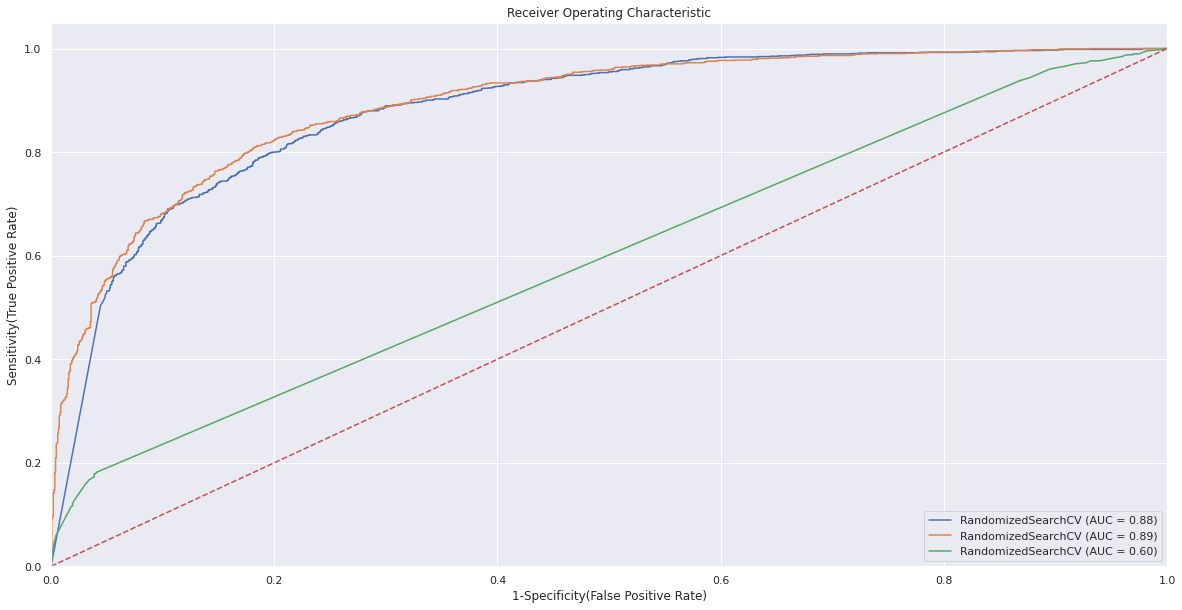

In [44]:
from sklearn.metrics import plot_roc_curve
plt.figure(figsize= (20,10))
classifiers = [gs_lr, gs_mnb, rf_best]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, x_test, y_test, ax=ax)
    
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

In [45]:
from sklearn.metrics import confusion_matrix
import itertools

#  Helper function to plot Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap='Accent'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

### Logistic Regression

Confusion matrix, without normalization
[[1167  339]
 [ 234 1122]]


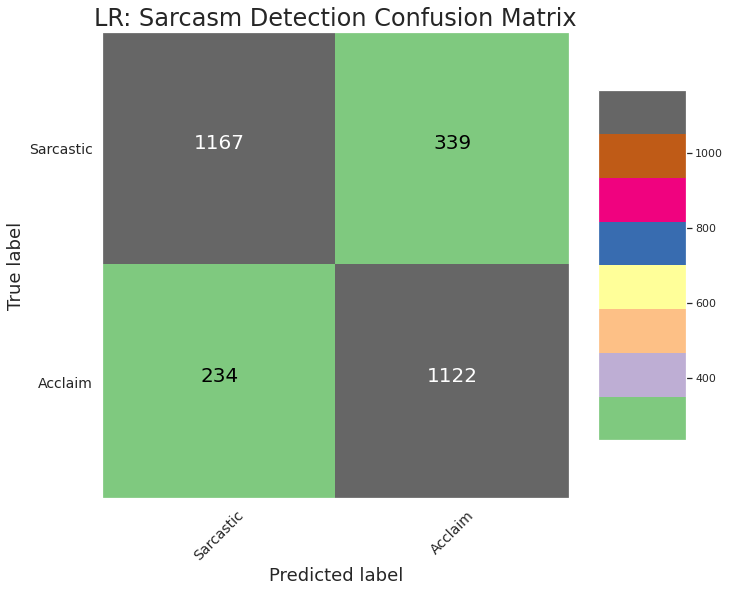

In [46]:
cm_lr = confusion_matrix(y_test, lr_predictions)
plot_confusion_matrix(cm_lr, classes = ['Sarcastic','Acclaim'],
                      title = 'LR: Sarcasm Detection Confusion Matrix')

### Best Random Forest

Confusion matrix, without normalization
[[1477   29]
 [1197  159]]


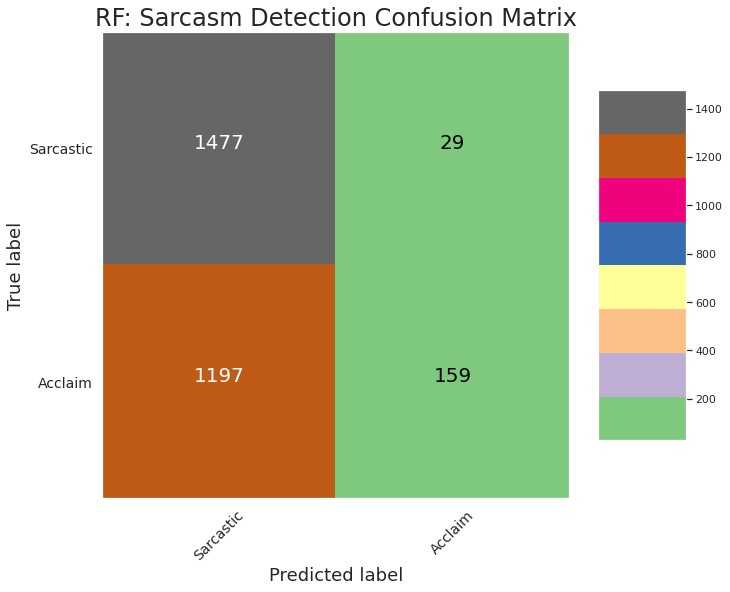

In [47]:
cm = confusion_matrix(y_test, rf_predictions)
plot_confusion_matrix(cm, classes = ['Sarcastic','Acclaim'],
                      title = 'RF: Sarcasm Detection Confusion Matrix')

### Naive Bayes

Confusion matrix, without normalization
[[1248  258]
 [ 281 1075]]


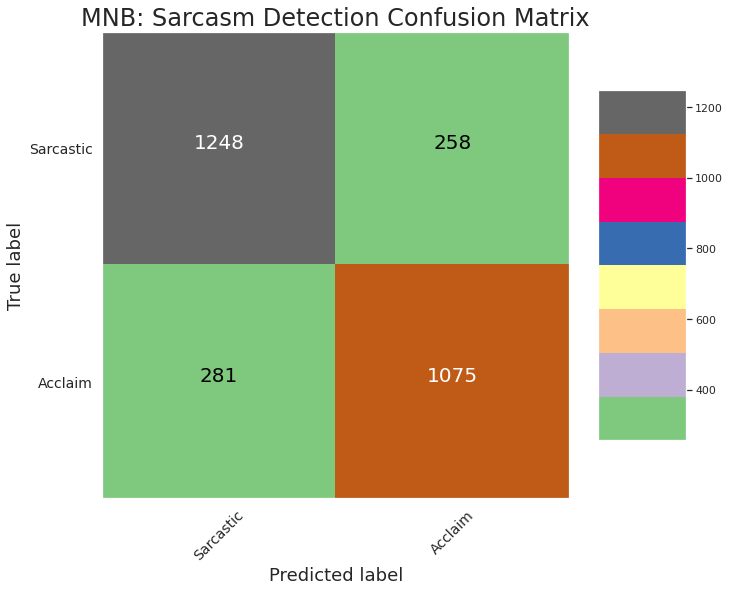

In [48]:
cm_mnb = confusion_matrix(y_test, mnb_predictions)
plot_confusion_matrix(cm_mnb, classes = ['Sarcastic','Acclaim'],
                      title = 'MNB: Sarcasm Detection Confusion Matrix')

In [ ]:
lr_train_accuracy = print_score(gs_lr,x_train,y_train,x_test,y_test,train=True)
lr_test_accuracy = print_score(gs_lr,x_train,y_train,x_test,y_test,train=False)

Training results:

Accuracy Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13479
           1       1.00      1.00      1.00     12278

    accuracy                           1.00     25757
   macro avg       1.00      1.00      1.00     25757
weighted avg       1.00      1.00      1.00     25757


Confusion Matrix:
[[13479     0]
 [    0 12278]]



In [ ]:
mnb_train_accuracy = print_score(gs_mnb,x_train,y_train,x_test,y_test,train=True)
mnb_test_accuracy = print_score(gs_mnb,x_train,y_train,x_test,y_test,train=False)

In [ ]:
rf_train_accuracy = print_score(rf_best.best_estimator_,x_train,y_train,x_test,y_test,train=True)
rf_test_accuracy = print_score(rf_best.best_estimator_,x_train,y_train,x_test,y_test,train=False)

In [ ]:
accuracy_all = pd.DataFrame({"Logistic Regression":[lr_train_accuracy,lr_test_accuracy],
              "MultilinearNB":[mnb_train_accuracy,mnb_test_accuracy],
              "Random Forest":[rf_train_accuracy,rf_test_accuracy]}, index=['Train','Test'])
accuracy_all